<a href="https://colab.research.google.com/github/ElaYJ/Study_Deep_Learning/blob/main/Framework/1_TensorFlow/10_FM_CNN_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functional 모델링 : ResNet 구현


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
np.random.seed(7777)
tf.random.set_seed(7777)

### ResNet

<img src="https://github.com/ElaYJ/supplement/assets/153154981/e2d3eb14-d790-40a3-bb56-2e19e186516d" width="97%">

### ResNet의 핵심은 Skip Connection

<img src="https://github.com/ElaYJ/supplement/assets/153154981/8750dbf2-595a-4349-b388-6684150ad4d7" width="57%">

### 2. Functional API

`tf.keras.Sequential` 보다 더 유연하게 모델을 정의할 수 있는 방법

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [5]:
## Functional API 를 이용해 ResNet 구현
def build_resnet(input_shape):
    inputs = Input(input_shape) # 28 x 28

    net0 = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs) # strides=2 이므로 14 x 14
    net0 = MaxPool2D()(net0) # 7 x 7

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net0)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net0_1 = Conv2D(64, kernel_size=1, padding='same')(net0)
    net = Add()([net0_1, net3])

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net = Add()([net, net3])

    net = MaxPool2D()(net)

    net = Flatten()(net)
    net = Dense(10, activation="softmax")(net)

    model = tf.keras.Model(inputs=inputs, outputs=net, name='resnet')

    return model

In [6]:
model = build_resnet((32, 32, 3)) #--> 컬러이미지
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 32)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             2112      ['max_pooling2d[0][0]']  

## CIfar10 dataset

> CIfar10 dataset을 이용해 학습을 해본다

In [7]:
class Cifar10DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(y, num_classes=10) for y in target])

        return scaled_x, ohe_y.squeeze(axis=1) # np.squeeze(ohe_y, axis=1)

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [8]:
cifar10_loader = Cifar10DataLoader()

train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

test_x, test_y = cifar10_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

170498071/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 32, 32, 3) float32
(10000, 10) float32


In [9]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [10]:
hist = model.fit(train_x, train_y,
                 epochs=10, batch_size=128,
                 validation_data=(test_x, test_y))

Epoch 1/10
391/391 [==============================] - 11s 13ms/step - loss: 2.3622 - accuracy: 0.0990 - val_loss: 2.3090 - val_accuracy: 0.1000
Epoch 2/10
391/391 [==============================] - 5s 12ms/step - loss: 2.3167 - accuracy: 0.1011 - val_loss: 2.3320 - val_accuracy: 0.1000
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 2.3146 - accuracy: 0.0991 - val_loss: 2.3092 - val_accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 2.3146 - accuracy: 0.1005 - val_loss: 2.3143 - val_accuracy: 0.1000
Epoch 5/10
391/391 [==============================] - 5s 12ms/step - loss: 2.3152 - accuracy: 0.1011 - val_loss: 2.3079 - val_accuracy: 0.1000
Epoch 6/10
391/391 [==============================] - 4s 9ms/step - loss: 2.3175 - accuracy: 0.0987 - val_loss: 2.3365 - val_accuracy: 0.1000
Epoch 7/10
391/391 [==============================] - 4s 9ms/step - loss: 2.3211 - accuracy: 0.1026 - val_loss: 2.3151 - val_accuracy: 0.1000


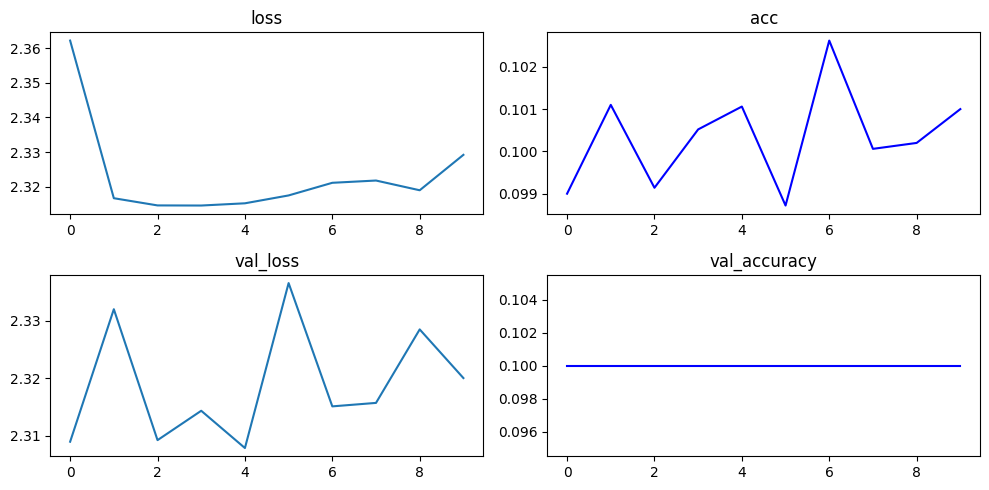

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(222)
plt.plot(hist.history['accuracy'], 'b-')
plt.title("acc")
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title("val_loss")
plt.subplot(224)
plt.plot(hist.history['val_accuracy'], 'b-')
plt.title("val_accuracy")

plt.tight_layout()
plt.show()